## Import necessary libraries

In [1]:
import os
import scipy
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython.display import display
import joblib
import warnings 
warnings.filterwarnings('ignore')

## Download the dataset using opendatasets

In [48]:
# dataset_url = "https://www.kaggle.com/datasets/ameythakur20/bangalore-house-prices"
# od.download(dataset_url, data_dir=r'D:\A Portfolio Projects\Data-Science-resume-projects\End_To_End_Bangalore_House_Price_Prediction\Dataset')

In [3]:
df = pd.read_csv(r"D:\A Portfolio Projects\Data-Science-resume-projects\End_To_End_Bangalore_House_Price_Prediction-main\Dataset\bangalore-house-prices\bengaluru_house_prices.csv")
df.shape

(13320, 9)

In [50]:
pd.concat([df.head(3), df.sample(3), df.tail(3)])

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
8723,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,3.0,309.00
13188,Super built-up Area,Ready To Move,Electronics City Phase 1,3 BHK,NaN,1700,3.0,2.0,111.00
4895,Built-up Area,Ready To Move,Whitefield,2 BHK,Vastael,1400,2.0,1.0,80.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00
13319,Super built-up Area,Ready To Move,Doddathoguru,1 BHK,NaN,550,1.0,1.0,17.00


In [51]:
# df.groupby('area_type')['area_type'].agg('count')
df.area_type.value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

## Drop unnecessary features

In [52]:
df = df.drop(columns=['area_type', 'availability', 'balcony', 'society'], axis=1)

In [53]:
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


## Data Cleaning

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13319 non-null  object 
 1   size        13304 non-null  object 
 2   total_sqft  13320 non-null  object 
 3   bath        13247 non-null  float64
 4   price       13320 non-null  float64
dtypes: float64(2), object(3)
memory usage: 520.4+ KB


we can clearly see there are null values present in the dataset

In [55]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

remove the null values

In [56]:
df = df.dropna()

In [57]:
df.isnull().sum().sum()

0

In [58]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

we can clearly see there are some messy values in the size feature

In [59]:
df['bhk'] = df['size'].apply(lambda x: int(x.split()[0]))

we solved the problem by creating a new feature bhk from size where it contains the num of bed rooms of each sample

In [60]:
# now we drop the size column as it became unnecessary
df = df.drop(columns=['size'])

In [61]:
# and changed the position of bhk for better visualization of input cols and target col
df.insert(2, 'bhk', df.pop('bhk'))

In [62]:
df

,location,total_sqft,bhk,bath,price
0,Electronic City Phase II,1056,2,2.0,39.07
1,Chikka Tirupathi,2600,4,5.0,120.00
2,Uttarahalli,1440,3,2.0,62.00
3,Lingadheeranahalli,1521,3,3.0,95.00
4,Kothanur,1200,2,2.0,51.00
...,...,...,...,...,...
13315,Whitefield,3453,5,4.0,231.00
13316,Richards Town,3600,4,5.0,400.00
13317,Raja Rajeshwari Nagar,1141,2,2.0,60.00
13318,Padmanabhanagar,4689,4,4.0,488.00


In [63]:
df.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

we can see the total_sqft column also contains some messy data such as '1133 - 1384'

In [64]:
# clean total_sqft
def clean_total_sqft(x):
    token = x.split('-')
    if len(token)==2:
        return (float(token[0])+float(token[1]))/2
    try:
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(clean_total_sqft)

## Feature Engineering

In [65]:
df['price_per_sqft'] = (df['price']*100000)/df['total_sqft']

In [66]:
location_freq = df.location.value_counts()

In [67]:
df['location'] = np.where(df['location'].isin(location_freq[location_freq<=10].index), 'Others', df['location'])

In [68]:
df.location.nunique()

242

In [69]:
df.describe(percentiles=[0.01, 0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.997, 0.999])

,total_sqft,bhk,bath,price,price_per_sqft
count,13200.000000,13246.000000,13246.000000,13246.000000,1.320000e+04
mean,1555.302783,2.801902,2.692586,112.389392,7.920759e+03
std,1237.323445,1.295758,1.341506,149.076587,1.067272e+05
min,1.000000,1.000000,1.000000,8.000000,2.678298e+02
1%,500.000000,1.000000,1.000000,18.725000,2.549754e+03
2%,582.488200,1.000000,1.000000,24.900000,2.799994e+03
10%,900.000000,2.000000,2.000000,38.000000,3.500268e+03
25%,1100.000000,2.000000,2.000000,50.000000,4.267701e+03
50%,1275.000000,3.000000,2.000000,72.000000,5.438331e+03
75%,1672.000000,3.000000,3.000000,120.000000,7.317073e+03


from the above describe func we can manually remove some outliers which are unexplainable. for example-
1) min total_sqft = 1
2) max total_sqft = 52272 which is a very extream outlier in our dataset. 
3) max num of bhk is 43. Is it a hotel i though im doing house price prediction
4) max num of bath is 40. am i dumb or extreamly poor
5) typically for a house max num of bath is total num of bed + 1 not more than that. for a 3 bed house max bath can be 4, for a 1 bed house max bath can be 2. 

In [70]:
# removed outlier manually
df = df[(df['total_sqft'] >= 500) & 
        (df['total_sqft'] <= 11978.110000) & 
        (df['bhk'] >= 1) & 
        (df['bhk'] <= 10) & 
        ((df['bhk'] + 1) >= df['bath'])]

In [71]:
df.describe(percentiles=[0.01, 0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.997, 0.999])

,total_sqft,bhk,bath,price,price_per_sqft
count,12881.000000,12881.000000,12881.000000,12881.000000,12881.000000
mean,1515.447522,2.775173,2.636286,108.014578,6610.507061
std,834.027820,1.157171,1.148487,130.589178,4182.223390
min,500.000000,1.000000,1.000000,10.500000,500.000000
1%,564.000000,1.000000,1.000000,21.000000,2550.253807
2%,600.000000,1.000000,1.000000,25.602000,2800.267960
10%,902.000000,2.000000,2.000000,38.190000,3500.361011
25%,1100.000000,2.000000,2.000000,50.000000,4259.818731
50%,1272.000000,3.000000,2.000000,71.000000,5414.551607
75%,1654.000000,3.000000,3.000000,117.000000,7223.476298


In [72]:
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include=object).columns
numerical_cols, categorical_cols

(Index(['total_sqft', 'bhk', 'bath', 'price', 'price_per_sqft'], dtype='object'),
 Index(['location'], dtype='object'))

In [73]:
def create_boxplot(df, col):
    px.box(df, x=col).show()

In [74]:
for col in numerical_cols:
    create_boxplot(df, col)

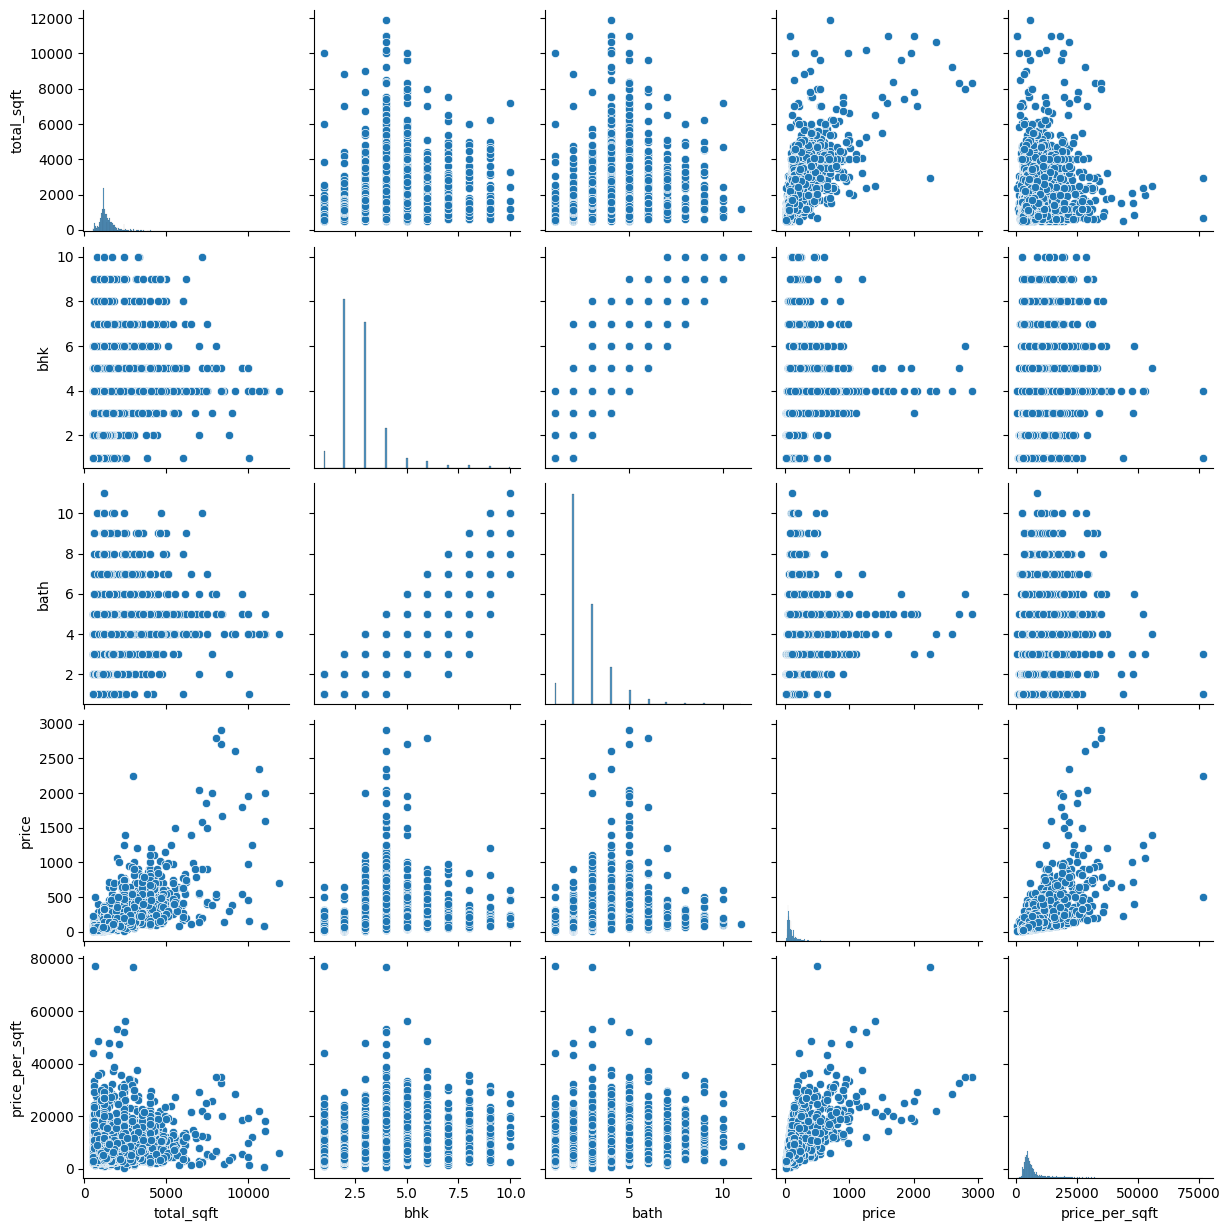

In [75]:
sns.pairplot(df[numerical_cols])

In [76]:
df.insert(4, 'price-per_sqft', df.pop('price_per_sqft'))

In [5]:
# Save the cleaned df
# df.to_csv(r"D:\A Portfolio Projects\Data-Science-resume-projects\End_To_End_Bangalore_House_Price_Prediction-main\Dataset\bangalore-house-prices\cleaned_bengaluru_house_prices.csv")

In [77]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((10304, 5), (2577, 5))

## Always test with a simple base avg model in regression problems

In [79]:
class MeanRegressor:
    def model_fit(self, X, y):
        self.mean = y.mean()
        
    def model_evaluate(self, y):
        rmse = mean_squared_error(y, np.full(len(y), self.mean), squared=False)
        r2 = r2_score(y, np.full(len(y), self.mean))
        print(f"RMSE: {rmse}")
        print(f"R2: {r2}")

In [80]:
mr = MeanRegressor()
mr.model_fit(X_train, y_train)
mr.model_evaluate(y_train)
mr.model_evaluate(y_test)

RMSE: 130.08101961074604
R2: 0.0
RMSE: 132.5827451312467
R2: -0.00046284461741086247


## pipeline

In [81]:
num_transformer = Pipeline(steps=[
    ('scale', MinMaxScaler())
])
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, X.select_dtypes(include=np.number).columns),
    ('cat', cat_transformer, X.select_dtypes(include=object).columns)
], remainder='passthrough'
)

In [82]:
models_params = {
    'LinearRegression' : [
        LinearRegression(),
        {}
        ],
    'Lasso' : [
        Lasso(),
        {
            'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'model__max_iter': [100, 500, 1000, 2000],
            'model__tol': [1e-4, 1e-3, 1e-2, 1e-1]
        }
    ],
    'Ridge' : [
        Ridge(),
        {
            'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'model__max_iter': [100, 500, 1000, 2000],
            'model__tol': [1e-4, 1e-3, 1e-2, 1e-1]          
        }
    ],
    'KNeighborsRegressor' : [
        KNeighborsRegressor(),
        {
            'model__n_neighbors': [3, 5, 10, 20, 25, 30],
            'model__weights': ['uniform', 'distance'],
            'model__p': [1, 2]
        }
    ],
    'SVR' : [
        SVR(),
        {
            'model__C': [0.1, 1, 10, 100],
            'model__epsilon': [0.01, 0.1, 0.5, 1],
            'model__kernel': ['linear', 'rbf']

        }
    ],
    'DecisionTreeRegressor' : [
        DecisionTreeRegressor(),
        {
            'model__max_depth': [50],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [2]  
        }
    ],
    'RandomForestRegressor' : [
        RandomForestRegressor(),
        {
            'model__oob_score' : [True],
            'model__n_estimators': [1000],
            'model__min_samples_leaf' : [2],
            'model__max_depth' : [30]
        }
    ],
    'GradientBoostingRegressor' : [
        GradientBoostingRegressor(),
        {
            'model__n_estimators': [1000],
            'model__learning_rate': [0.01],
            'model__max_depth': [8],
            'model__min_samples_leaf': [2]
        }
    ],
    'AdaBoostRegressor' : [
        AdaBoostRegressor(),
        {
            'model__n_estimators': [1000],             
            'model__learning_rate': [0.001, 0.01],         
        }
    ]
}

In [92]:
result_df = pd.DataFrame(columns=['model_name', 'best_parameter', 'cv_score_rmse', 'test_score_rmse', 'cv_score_r2', 'test_score_r2'])
def add_record_to_df(result_df, model_name, best_params, cv_rmse, test_rmse, cv_r2, test_r2):
    result_df.loc[len(result_df)] = [model_name, best_params, cv_rmse, test_rmse, cv_r2, test_r2]
    display(result_df[-1:])

def test_predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    test_r2 = r2_score(y_test, y_pred)
    return test_rmse, test_r2

def save_model(model, filename):
    path = r"D:\A Portfolio Projects\Data-Science-resume-projects\End_To_End_Bangalore_House_Price_Prediction\models"
    joblib.dump(model, os.path.join(path, filename))

In [93]:
for model_name, (model, param) in models_params.items():
    m = Pipeline(steps=[
        ('pre', preprocessor),
        ('model', model)
    ])
    if not param:
        cv_score = cross_validate(estimator=m, X=X_train, y=y_train, cv =5, n_jobs=-1, scoring=['neg_root_mean_squared_error', 'r2'])
        cv_rmse = -cv_score['test_neg_root_mean_squared_error'].mean()
        cv_r2 = cv_score['test_r2'].mean()
        m.fit(X_train, y_train)
        test_rmse, test_r2 = test_predict(m, X_test, y_test)
        add_record_to_df(result_df, model_name, None, cv_rmse, test_rmse, cv_r2, test_r2)
        save_model(m, model_name+'.joblib')
    else:
        model_grid = GridSearchCV(estimator=m, cv=5, param_grid=param, scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error', n_jobs=-1)
        model_grid.fit(X_train, y_train)
        cv_rmse = -model_grid.cv_results_['mean_test_neg_root_mean_squared_error'][model_grid.best_index_]
        cv_r2 =  model_grid.cv_results_['mean_test_r2'][model_grid.best_index_]
        test_rmse, test_r2 = test_predict(model_grid.best_estimator_, X_test, y_test)
        add_record_to_df(result_df, model_name, str(model_grid.best_params_), cv_rmse, test_rmse, cv_r2, test_r2)
        save_model(model_grid.best_estimator_, model_name+'.joblib')
    


,model_name,best_parameter,cv_score_rmse,test_score_rmse,cv_score_r2,test_score_r2
0,LinearRegression,None,53.378307,45.968174,0.831287,0.879734


,model_name,best_parameter,cv_score_rmse,test_score_rmse,cv_score_r2,test_score_r2
1,Lasso,"{'model__alpha': 0.01, 'model__max_iter': 100,...",53.26443,45.967493,0.831999,0.879738


,model_name,best_parameter,cv_score_rmse,test_score_rmse,cv_score_r2,test_score_r2
2,Ridge,"{'model__alpha': 0.1, 'model__max_iter': 100, ...",53.362057,45.99983,0.831389,0.879569


,model_name,best_parameter,cv_score_rmse,test_score_rmse,cv_score_r2,test_score_r2
3,KNeighborsRegressor,"{'model__n_neighbors': 3, 'model__p': 2, 'mode...",55.200885,65.661393,0.814759,0.754615


,model_name,best_parameter,cv_score_rmse,test_score_rmse,cv_score_r2,test_score_r2
4,SVR,"{'model__C': 100, 'model__epsilon': 0.01, 'mod...",53.558365,55.741677,0.829561,0.823157


,model_name,best_parameter,cv_score_rmse,test_score_rmse,cv_score_r2,test_score_r2
5,DecisionTreeRegressor,"{'model__max_depth': 50, 'model__min_samples_l...",22.440882,31.360829,0.969073,0.944024


,model_name,best_parameter,cv_score_rmse,test_score_rmse,cv_score_r2,test_score_r2
6,RandomForestRegressor,"{'model__max_depth': 30, 'model__min_samples_l...",19.474393,25.875824,0.976614,0.961892


,model_name,best_parameter,cv_score_rmse,test_score_rmse,cv_score_r2,test_score_r2
7,GradientBoostingRegressor,"{'model__learning_rate': 0.01, 'model__max_dep...",17.337176,24.44607,0.98132,0.965987


,model_name,best_parameter,cv_score_rmse,test_score_rmse,cv_score_r2,test_score_r2
8,AdaBoostRegressor,"{'model__learning_rate': 0.01, 'model__n_estim...",47.242842,51.622675,0.864392,0.848327


In [94]:
result_df

,model_name,best_parameter,cv_score_rmse,test_score_rmse,cv_score_r2,test_score_r2
0,LinearRegression,None,53.378307,45.968174,0.831287,0.879734
1,Lasso,"{'model__alpha': 0.01, 'model__max_iter': 100,...",53.264430,45.967493,0.831999,0.879738
2,Ridge,"{'model__alpha': 0.1, 'model__max_iter': 100, ...",53.362057,45.999830,0.831389,0.879569
3,KNeighborsRegressor,"{'model__n_neighbors': 3, 'model__p': 2, 'mode...",55.200885,65.661393,0.814759,0.754615
4,SVR,"{'model__C': 100, 'model__epsilon': 0.01, 'mod...",53.558365,55.741677,0.829561,0.823157
5,DecisionTreeRegressor,"{'model__max_depth': 50, 'model__min_samples_l...",22.440882,31.360829,0.969073,0.944024
6,RandomForestRegressor,"{'model__max_depth': 30, 'model__min_samples_l...",19.474393,25.875824,0.976614,0.961892
7,GradientBoostingRegressor,"{'model__learning_rate': 0.01, 'model__max_dep...",17.337176,24.446070,0.981320,0.965987
8,AdaBoostRegressor,"{'model__learning_rate': 0.01, 'model__n_estim...",47.242842,51.622675,0.864392,0.848327


### we can clearly see GradientBoostingRegressor is the best model with highest r2 and lowerst mrse